In [1]:
import os
import sys
import inspect
from importlib import reload
from tqdm import tqdm
from pathlib import Path

import numpy as np
import numexpr as ne
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.constants import pi, c, epsilon_0, mu_0, alpha, m_e, hbar, e
from scipy.spatial.transform import Rotation
import pyfftw
# from ax.service.ax_client import AxClient

rcParams['figure.figsize'] = (8,6)
rcParams['font.size'] = 20

import quvac
from quvac.field.gaussian import GaussianAnalytic
from quvac.field.external_field import ExternalField
from quvac.field.maxwell import MaxwellMultiple
from quvac.field.utils import get_field_energy, get_field_energy_kspace
from quvac.integrator.vacuum_emission import VacuumEmission
from quvac.analytic_scalings import get_two_paraxial_scaling
from quvac.grid import GridXYZ, get_xyz_size, get_t_size, setup_grids
from quvac.utils import write_yaml, read_yaml
from quvac.simulation import quvac_simulation
# from quvac.cluster.optimization import gather_trials_data

## Create default config for tests

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w01 = 1*lam
w02 = 1*lam
theta = 180
beta = 0

mode = 'maxwell'
order = 0

# Define fields
field_1 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w01,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w02,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

fields_params = {
    'field_1': field_1,
    'field_2': field_2,
}

integrator_type = 'vacuum_emission'
    
ini_data = {
    'fields': fields_params,
    'grid': {
        'mode': 'dynamic',
        'collision_geometry': 'z',
        'transverse_factor': 15,
        'longitudinal_factor': 6,
        'time_factor': 4,
        'spatial_resolution': 1,
        'time_resolution': 1,
    },
    'integrator': {
        'type': integrator_type,
    },
    'performance': {
        'nthreads': 8,
        'pyfftw_threads': 1,
    },
    'postprocess': {
        'perp_polarization_type': 'optical axis',
        'perp_field_idx': 1,
        'calculate_spherical': False,
        'spherical_params': {
            'angular_resolution': 1*np.pi/180.  
        },
        'calculate_discernible': False,
    },
}
    
path = f'../tests'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'default_config.yml')
write_yaml(ini_file, ini_data)

## Launch a single simulation

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam1 = 0.8e-6/1
lam2 = 0.8e-6
w01 = 1*lam2
w02 = 1*lam2
theta = 180
beta = 0

mode = 'maxwell'
order = 0
# parallel = True
parallel = False

channels = False
integrator_type = 'vacuum_emission_channels' if channels else 'vacuum_emission'

# Define fields
field_1 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam1,
    "w0": w01,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam2,
    "w0": w02,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

fields_params = {
    'field_1': field_1,
    'field_2': field_2,
}

ini_data = {
    'mode': 'postprocess',
    'fields': fields_params,
    'grid': {
        'mode': 'dynamic',
        'collision_geometry': 'z',
        'transverse_factor': 15,
        'longitudinal_factor': 6,
        'time_factor': 4,
        'spatial_resolution': 1,
        'time_resolution': 1,
    },
    'integrator': {
        'type': integrator_type,
        'probe_pump_idx': {
            'probe': [1],
            'pump': [0],
        }
    },
    'performance': {
        'nthreads': 8,
        'pyfftw_threads': 1,
        'test_run': False,
        'precision': 'float64',
        'use_wisdom': False
    },
    'cluster_params': {
        'n_jobs': 1,},
    'postprocess': {
        'perp_polarization_type': 'optical axis',
        'perp_field_idx': 1,
        'calculate_spherical': False,
        'spherical_params': {
            'angular_resolution': 1*np.pi/180.  
        },
        'calculate_discernible': False,
    },
}

path = '../data/test/test_no_post1'
if parallel:
    path += '_parallel'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'ini.yaml')
write_yaml(ini_file, ini_data)

# quvac_simulation(ini_file)
if not parallel:
    SCRIPT_PATH = '../src/quvac/simulation.py'
else:
    SCRIPT_PATH = '../src/quvac/simulation_parallel.py'

In [3]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file}")


Postprocess:
Time:                               0.05 s
----------------------------------------------------
Memory (max usage):              107.16 MB

Simulation finished!


In [5]:
Ntot = data['N_sph_total']
print(Ntot)

KeyError: 'N_sph_total is not a file in the archive'

In [5]:
list(data.keys())

['kx',
 'ky',
 'kz',
 'N_xyz',
 'N_total',
 'ep',
 'Np_xyz',
 'Np_total',
 'k',
 'theta',
 'phi',
 'N_sph',
 'N_sph_total',
 'Np_sph',
 'Np_sph_total',
 'background',
 'discernible',
 'N_disc',
 'N_angular']

In [6]:
perf = read_yaml(os.path.join(path, 'performance.yml'))
perf

{'memory': {'maxrss_amplitudes': 420296, 'maxrss_total': 420296},
 'timings': {'amplitudes': 39180.043704731,
  'field_setup': 39129.133226834,
  'per_iteration': 0.22626879065333116,
  'postprocess': 39180.13091673,
  'start': 39128.406564429,
  'vacem_setup': 39129.134328236}}

In [6]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file}")


Timings:
Run jobs:                          39.33 s
Postprocess:                        0.09 s
----------------------------------------------------
Total:                             39.43 s

Memory (max usage):
Running jobs:                    126.41 MB
Total:                           169.54 MB

Simulation finished!


In [7]:
data = np.load(os.path.join(path, 'spectra.npz'))
Ntot = data['N_total']
print(Ntot)

258.9193047337835


In [9]:
0 + np.array([1 + 2j])

array([1.+2.j])

In [6]:
data_file = os.path.join(path, 'spectra.npz')
data = np.load(data_file)
print(list(data.keys()))

N_signal_num = data['N_total']
print(N_signal_num)
print(data['Np_total'])

['kx', 'ky', 'kz', 'N_xyz', 'N_total', 'ep', 'Np_xyz', 'Np_total']
0.00024635849609903307
2.1450162199580958e-06


In [6]:
k, theta, phi = [data[key] for key in 'k theta phi'.split()]
N_sph = data['N_sph']

KeyError: 'k is not a file in the archive'

In [6]:
print(data['N_total'])
print(data['N_sph_total'])
print(data['N_disc'])

43.1971270730111
42.975513574112306
0.6713467712605758


In [5]:
N_signal_th, N_perp_th = get_two_paraxial_scaling(fields_params)
N_signal_th

28.380257254278188

In [7]:
N_signal_th / N_signal_num

0.9847895916295691

## Compare time for sequential and parallel execution

In [3]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w01 = 4*lam
w02 = 1*lam
theta = 180
beta = 0

mode = 'maxwell'
order = 0
parallel = True
parallel = False

channels = False
integrator_type = 'vacuum_emission_channels' if channels else 'vacuum_emission'

# Define fields
field_1 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w01,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w02,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

fields_params = {
    'field_1': field_1,
    'field_2': field_2,
}

ini_data = {
    'fields': fields_params,
    'grid': {
        'mode': 'dynamic',
        'collision_geometry': 'xz',
        'transverse_factor': 20,
        'longitudinal_factor': 8,
        'time_factor': 4,
        'spatial_resolution': 1,
        'time_resolution': 2,
    },
    'integrator': {
        'type': integrator_type,
        'probe_pump_idx': {
            'probe': [1],
            'pump': [0],
        }
    },
    'performance': {
        'nthreads': 8,
        'test_run': False
    },
    'cluster_params': {
        'n_jobs': 1,
        'cluster': 'slurm',
        'sbatch_params': {
            'slurm_partition': 'hij-gpu',
            'cpus_per_task': 16,
            'slurm_mem': '100GB',
            'timeout_min': 240,
        },
    },
    'postprocess': {
        'perp_polarization_type': 'optical axis',
        'perp_field_idx': 1,
        'calculate_spherical': False,
        'spherical_params': {
            'angular_resolution': 0.5*np.pi/180.  
        },
        'calculate_discernible': False,
    },
}

if not parallel:
    SCRIPT_PATH = '../src/quvac/simulation.py'
else:
    SCRIPT_PATH = '../src/quvac/simulation_parallel.py'

path = '../data/test/test'
if parallel:
    path += '_parallel'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'ini.yaml')
write_yaml(ini_file, ini_data)

In [3]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file}")


Timings:
Field setup:                        1.18 s
Vacem setup:                        0.00 s
Amplitudes calculation:       4 min 9.37 s
    Per time step:                  0.13 s
Postprocess:                        0.55 s
----------------------------------------------------
Total:                       4 min 10.68 s

Memory (max usage):
Amplitudes calculation:          805.47 MB
Total:                           805.47 MB

Simulation finished!


In [4]:
data = np.load(os.path.join(path, 'spectra.npz'))
Ntot = data['N_total']
print(Ntot)

259.2391650892998


In [5]:
SCRIPT_PATH = '../src/quvac/simulation_parallel.py'

job_paths = []
n_jobs = [1, 2, 3, 4, 6, 8]
for n_job in n_jobs:
    print('='*30)
    print(f'# of jobs: {n_job}')
    
    ini_data['cluster_params']['n_jobs'] = n_job
    path = f'../data/test/parallel/parallel_{n_job}_jobs'
    Path(path).mkdir(parents=True, exist_ok=True)
    job_paths.append(path)
    ini_file = os.path.join(path, 'ini.yaml')
    write_yaml(ini_file, ini_data)

    status = os.system(f"{SCRIPT_PATH} --input {ini_file}")

    data = np.load(os.path.join(path, 'spectra.npz'))
    Ntot = data['N_total']
    print(f'N total: {Ntot:.3f}')

# of jobs: 1


Traceback (most recent call last):
  File "/home/maximus/Research/github/quantum-vacuum/notebooks/../src/quvac/simulation_parallel.py", line 232, in <module>
    quvac_simulation_parallel(args.input, args.output, args.wisdom)
  File "/home/maximus/Research/github/quantum-vacuum/notebooks/../src/quvac/simulation_parallel.py", line 155, in quvac_simulation_parallel
    ini_files = create_ini_files_for_parallel(ini_config, grid_xyz, grid_t,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maximus/Research/github/quantum-vacuum/notebooks/../src/quvac/simulation_parallel.py", line 55, in create_ini_files_for_parallel
    box_t = [float(grid_t[idx_start]), float(grid_t[idx_end])]
                                             ~~~~~~^^^^^^^^^
IndexError: index 451 is out of bounds for axis 0 with size 451


FileNotFoundError: [Errno 2] No such file or directory: '../data/test/parallel/parallel_{}_jobs/spectra.npz'

## Test total signal and signal separated into channels

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w01 = 1*lam
w02 = 1*lam
theta = 180
beta = 0

mode = 'maxwell'
order = 0

# Define fields
field_1 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w01,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w02,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

fields_params = {
    'field_1': field_1,
    'field_2': field_2,
}

results = []
result_str = ''

for idx,channels in zip([(0,0), (0,1), (1,0)], [False, True, True]):
    integrator_type = 'vacuum_emission_channels' if channels else 'vacuum_emission'
    
    ini_data = {
        'fields': fields_params,
        'grid': {
            'mode': 'dynamic',
            'collision_geometry': 'z',
            'transverse_factor': 15,
            'longitudinal_factor': 6,
            'time_factor': 4,
            'spatial_resolution': 1,
            'time_resolution': 1,
        },
        'integrator': {
            'type': integrator_type,
            'probe_pump_idx': {
                'probe': [idx[0]],
                'pump': [idx[1]],
            }
        },
        'performance': {
            'nthreads': 8
        },
        'postprocess': {
            'perp_polarization_type': 'optical axis',
            'perp_field_idx': 1,
            'calculate_spherical': False,
            'spherical_params': {
                'angular_resolution': 0.5*np.pi/180.  
            },
            'calculate_discernible': False,
        },
    }
    
    path = f'../data/test/test_channels_{idx[0]}_{idx[1]}'
    Path(path).mkdir(parents=True, exist_ok=True)
    
    ini_file = os.path.join(path, 'ini.yml')
    write_yaml(ini_file, ini_data)
    
    # quvac_simulation(ini_file)
    SCRIPT_PATH = '../src/quvac/simulation.py'

    status = os.system(f"{SCRIPT_PATH} --input {ini_file}")

    data_file = os.path.join(path, 'spectra.npz')
    data = np.load(data_file)
    
    N_signal_num = data['N_total']
    results.append(N_signal_num)
    result_str += f'channels {channels:>5}, {idx}: {N_signal_num:.3f}\n'
    # print(f'channels {channels}, {idx}: {N_signal_num:.3f}')


Timings:
Field setup:                        0.54 s
Vacem setup:                        0.00 s
Amplitudes calculation:            12.32 s
Postprocess:                        0.03 s
-------------------------------------------------
Per iteration:                      0.05 s  
-------------------------------------------------
Total:                             12.89 s

Memory (max usage):
Amplitudes calculation:          193.68 MB
Total:                           193.68 MB

Simulation finished!

Timings:
Field setup:                        0.57 s
Vacem setup:                        0.01 s
Amplitudes calculation:            18.31 s
Postprocess:                        0.02 s
-------------------------------------------------
Per iteration:                      0.08 s  
-------------------------------------------------
Total:                             18.90 s

Memory (max usage):
Amplitudes calculation:          260.89 MB
Total:                           260.89 MB

Simulation finished!

T

In [3]:
print(result_str)

channels     0, (0, 0): 258.765
channels     1, (0, 1): 129.075
channels     1, (1, 0): 129.075



In [5]:
path = f'../data/test/test_channels_0_1'
data_file = os.path.join(path, 'spectra.npz')
data1 = np.load(data_file)

path = f'../data/test/test_channels_1_0'
data_file = os.path.join(path, 'spectra.npz')
data2 = np.load(data_file)
list(data.keys())

['kx', 'ky', 'kz', 'N_xyz', 'N_total', 'ep', 'Np_xyz', 'Np_total']

In [6]:
print(data1['kx'][:10])
print(data2['kx'][:10])

[-7853981.63397448 -7330382.85837618 -6806784.08277788 -6283185.30717958
 -5759586.53158128 -5235987.75598298 -4712388.98038469 -4188790.20478639
 -3665191.42918809 -3141592.65358979]
[-7853981.63397448 -7330382.85837618 -6806784.08277788 -6283185.30717958
 -5759586.53158128 -5235987.75598298 -4712388.98038469 -4188790.20478639
 -3665191.42918809 -3141592.65358979]


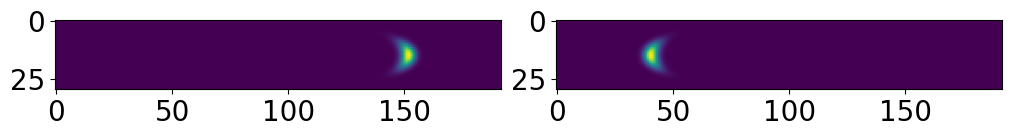

In [8]:
idx = 15
plt.figure(figsize=(10,4), layout='constrained')

plt.subplot(1,2,1)
plt.imshow(data1['N_xyz'][:,idx,:])
# plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(data2['N_xyz'][:,idx,:])
# plt.colorbar()

plt.show()

## How fields in spatial domain look like

In [13]:
grid_params = {
    'mode': 'dynamic',
    'collision_geometry': 'z',
    'transverse_factor': 15,
    'longitudinal_factor': 6,
    'time_factor': 4,
    'spatial_resolution': 1,
    'time_resolution': 1,
}
grid_xyz, grid_t = setup_grids(fields_params, grid_params)

In [16]:
field1_cls = GaussianAnalytic(field_1, grid_xyz)
field2_cls = GaussianAnalytic(field_2, grid_xyz)

Initial energy: 2.090302980676826e-09
Initial energy: 2.0903029806768254e-09


In [17]:
E1, B1 = field1_cls.calculate_field(0)
E2, B2 = field2_cls.calculate_field(0)

In [43]:
np.allclose(E1[0][:,idx,:], -1*E2[0][:,idx,:])

True

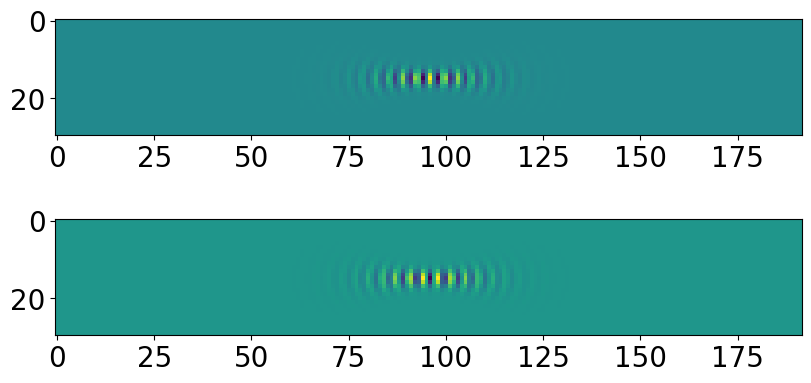

In [24]:
idx = 15

plt.figure(figsize=(8,4), layout='constrained')
plt.subplot(2,1,1)
plt.imshow(E1[0][:,idx,:])

plt.subplot(2,1,2)
plt.imshow(E2[0][:,idx,:])
plt.show()

## Test different HO gauss orders

In [5]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w01 = 1*lam
w02 = 1*lam
theta = 180
beta = 0

mode = 'analytic'
# order = 2
orders = [i for i in range(6)]
results = []

for order in orders:
    # Define fields
    field_1 = {
        "field_type": f"paraxial_gaussian_{mode}",
        "focus_x": [0.,0.,0.],
        "focus_t": 0.,
        "theta": 0,
        "phi": 0,
        "beta": 0,
        "lam": lam,
        "w0": w01,
        "tau": tau,
        "W": W,
        "phase0": 0,
        "order": order,
    }
    
    field_2 = {
        "field_type": f"paraxial_gaussian_{mode}",
        "focus_x": [0.,0.,0.],
        "focus_t": 0.,
        "theta": theta,
        "phi": 0,
        "beta": beta,
        "lam": lam,
        "w0": w02,
        "tau": tau,
        "W": W,
        "phase0": 0,
        "order": order,
    }
    
    fields_params = {
        'field_1': field_1,
        'field_2': field_2,
    }
    
    ini_data = {
        'fields': fields_params,
        'grid': {
            'mode': 'dynamic',
            'collision_geometry': 'z',
            'transverse_factor': 15,
            'longitudinal_factor': 6,
            'time_factor': 4,
            'spatial_resolution': 1,
            'time_resolution': 1,
        },
        'performance': {
            'nthreads': 8
        },
        'postprocess': {
            'perp_polarization_type': 'optical axis',
            'perp_field_idx': 1,
            'calculate_spherical': False,
            'calculate_discernible': False,
        },
    }
    
    path = f'../data/test/test_ho_gauss_order_{order}'
    Path(path).mkdir(parents=True, exist_ok=True)
    
    ini_file = os.path.join(path, 'ini.yaml')
    write_yaml(ini_file, ini_data)
    
    # quvac_simulation(ini_file)
    SCRIPT_PATH = '../src/quvac/simulation.py'

    status = os.system(f"{SCRIPT_PATH} --input {ini_file}")

    data_file = os.path.join(path, 'spectra.npz')
    data = np.load(data_file)
    
    N_signal_num = data['N_total']
    results.append(N_signal_num)

Energy: 2.0903029806769896e-29
Energy: 2.090302980676989e-29

Timings:
Field setup:                        0.08 s
Vacem setup:                        0.01 s
Amplitudes calculation:            12.85 s
Postprocess:                        0.03 s
-------------------------------------------------
Per iteration:                      0.06 s  
-------------------------------------------------
Total:                             12.96 s

Memory (max usage):
Amplitudes calculation:          180.76 MB
Total:                           180.76 MB

Simulation finished!
Energy: 2.1432509703168072e-29
Energy: 2.1432509703168072e-29

Timings:
Field setup:                        0.15 s
Vacem setup:                        0.01 s
Amplitudes calculation:            13.94 s
Postprocess:                        0.04 s
-------------------------------------------------
Per iteration:                      0.06 s  
-------------------------------------------------
Total:                             14.14 s

Memory 

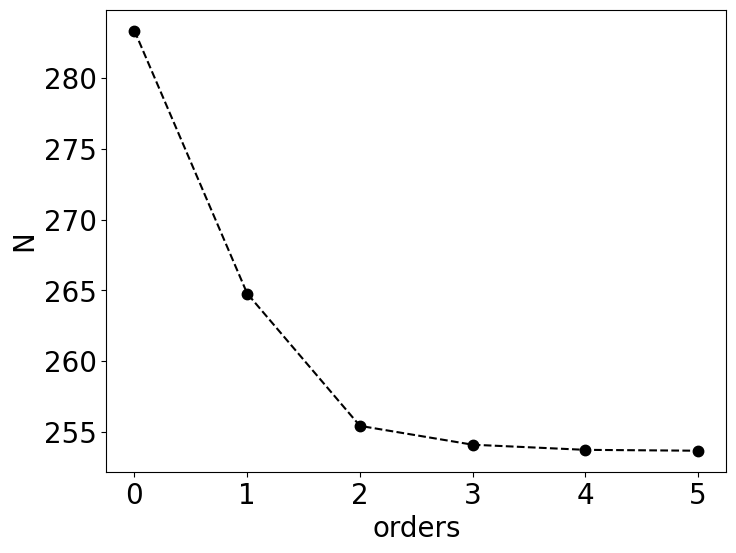

In [7]:
plt.figure()
plt.plot(orders, results, '.--', color='black', ms=15)
plt.xlabel('orders')
plt.ylabel('N')
plt.show()

## Launch a gridscan

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w01 = 1*lam
w02 = 1*lam
theta = 180
beta = 90

mode = 'maxwell'

# Define fields
field_1 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w01,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w02,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = {
    'field_1': field_1,
    'field_2': field_2,
}

ini_data = {
    'fields': fields_params,
    'grid': {
        'mode': 'dynamic',
        'collision_geometry': 'z',
        'transverse_factor': 15,
        'longitudinal_factor': 6,
        'time_factor': 4,
        'spatial_resolution': 1,
        'time_resolution': 1,
    },
    'performance': {
        'nthreads': 8
    },
    'postprocess': {
        'calculate_spherical': False,
        'calculate_discernible': False,
    },
}

variables_data = {
    'create_grids': True,
    'fields': {
        'field_2': {
            'beta': [0, 90, 3]
        }
    }
}

path = '../data/test/test_gridscan'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'ini.yaml')
write_yaml(ini_file, ini_data)

variables_file = os.path.join(path, 'variables.yaml')
write_yaml(variables_file, variables_data)

# quvac_simulation(ini_file)
SCRIPT_PATH = '../src/quvac/cluster/gridscan.py'

In [3]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file} --variables {variables_file}")

Submitting jobs...
Jobs submitted, waiting for results...
Grid scan is finished!


### Chech results

In [6]:
data_path = '../data/test/test_gridscan'

folders = [f'#field_2:beta_{beta}' for beta in [0, 45, 90]]
data = []
for folder in folders:
    data_loc = np.load(os.path.join(data_path, folder, 'spectra.npz'))
    data.append(data_loc['N_total'])

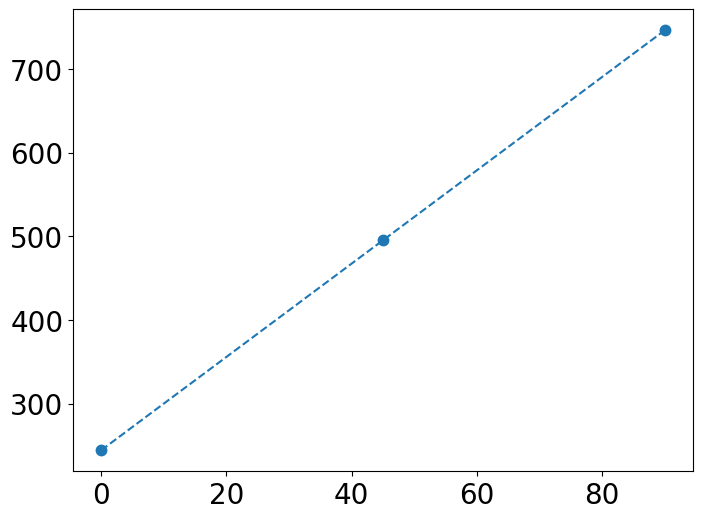

In [8]:
plt.plot([0,45,90], data, '.--', ms=15)

In [10]:
print(data[1] / data[0])
print(130 / 64)
print(data[2] / data[1])
print(196 / 130)

2.027098521413737
2.03125
1.5066464812492895
1.5076923076923077


## Launch optimization

In [4]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w01 = 1*lam
w02 = 1*lam
theta = 160
beta = 90
order = 5

mode = 'maxwell'

# Define fields
field_1 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w01,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w02,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

fields_params = {
    'field_1': field_1,
    'field_2': field_2,
}

path = '../data/test/test_optimization'
Path(path).mkdir(parents=True, exist_ok=True)

ini_data = {
    'fields': fields_params,
    'grid': {
        'mode': 'dynamic',
        'collision_geometry': 'z',
        'transverse_factor': 15,
        'longitudinal_factor': 6,
        'time_factor': 4,
        'spatial_resolution': 1,
        'time_resolution': 1,
    },
    'performance': {
        'nthreads': 8
    },
    'postprocess': {
        'calculate_spherical': True,
        'calculate_discernible': True,
    },
    'scales': {
        'tau': 1e-15
    },
    'save_path': path
}

optimization_data = {
    'name': '2_pulses_tau',
    'parameters': {
        'field_2': {
            'tau': [15, 30]
        }
    },
    'cluster': {
        'cluster': 'local',
    },
    'n_trials': 10,
    'objectives': [['N_total', False]],
    
}

path = '../data/test/test_optimization'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'ini.yml')
write_yaml(ini_file, ini_data)

optimization_file = os.path.join(path, 'optimization.yml')
write_yaml(optimization_file, optimization_data)

# quvac_simulation(ini_file)
SCRIPT_PATH = '../src/quvac/cluster/optimization.py'

In [5]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file} --optimization {optimization_file}")

[INFO 10-23 13:42:17] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 10-23 13:42:17] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='field_2:beta', parameter_type=FLOAT, range=[0.0, 90.0]), FixedParameter(name='ini_default', parameter_type=STRING, value='../data/test/test_optimization/ini.yml')], parameter_constraints=[]).
[INFO 10-23 13:42:17] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 10-23 13:42:17] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=1 num_trials=None use_batch_trials=False
[INFO 10-23 13:42:17] ax.modelbridge.di

Optimization finished!


### Check results

In [7]:
save_path = '../data/test/test_optimization'
client_json = os.path.join(save_path, 'experiment.json')
ax_client = (AxClient.load_from_json_file(client_json))

[INFO 10-23 13:45:16] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [29]:
trials_params = gather_trials_data(ax_client, metric_names=['N_total'])
betas = [val['field_2:beta'] for val in trials_params.values()]
N_total = [val['N_total'] for val in trials_params.values()]

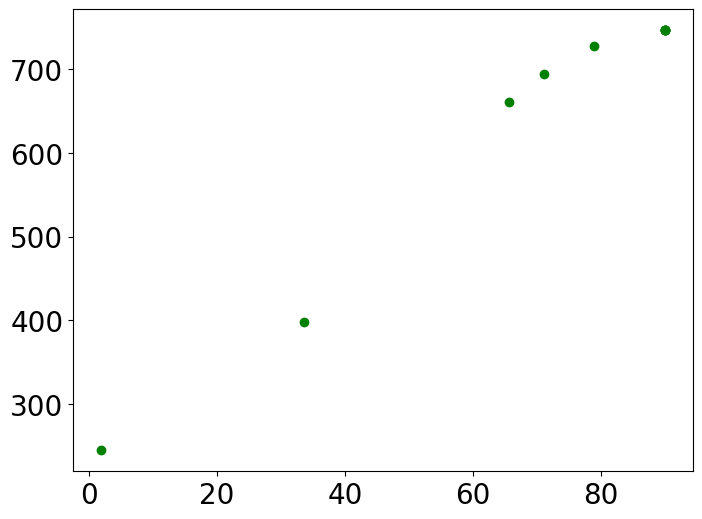

In [30]:
plt.figure()
plt.scatter(betas, N_total, color='green')
plt.show()

### Test how a1, a2 look like

In [10]:
ini_config = read_yaml(ini_file)
fields_params = ini_config["fields"]
grid_params = ini_config["grid"]
perf_params = ini_config["performance"]
nthreads = perf_params['nthreads']

grid_xyz, grid_t = setup_grids(fields_params, grid_params)
field = ExternalField(fields_params, grid_xyz, nthreads=nthreads)
grid_xyz.get_k_grid()
dVk = grid_xyz.dVk

amplitudes_path = os.path.join(path, 'amplitudes.npz')
data = np.load(amplitudes_path)
s1, s2 = data['S1'], data['S2']

s1_real = np.sum(s1.real) * dVk / (2*pi)**3
s1_imag = np.sum(s1.imag) * dVk / (2*pi)**3

s2_real = np.sum(s2.real) * dVk / (2*pi)**3
s2_imag = np.sum(s2.imag) * dVk / (2*pi)**3
print(f's1 real: {s1_real}')
print(f's1 imag: {s1_imag}')

print(f's2 real: {s2_real}')
print(f's2 imag: {s2_imag}')

s1 real: 1.5672026691683959e-09
s1 imag: -9.877871510245512e-09
s2 real: 3.360367860975565e-09
s2 imag: -1.6330722306896097e-08


In [18]:
x,y,z = grid_xyz.grid
grid_shape = nx,ny,nz = grid_xyz.grid_shape
E_out = [np.zeros(grid_shape) for _ in range(3)]
B_out = [np.zeros(grid_shape) for _ in range(3)]

t = 1e-15
E_out, B_out = field.calculate_field(t, E_out, B_out)

W = get_field_energy(E_out, B_out, grid_xyz.dV)
print(W)

49.99999997570632


5022939.295592608
148394.57312882377


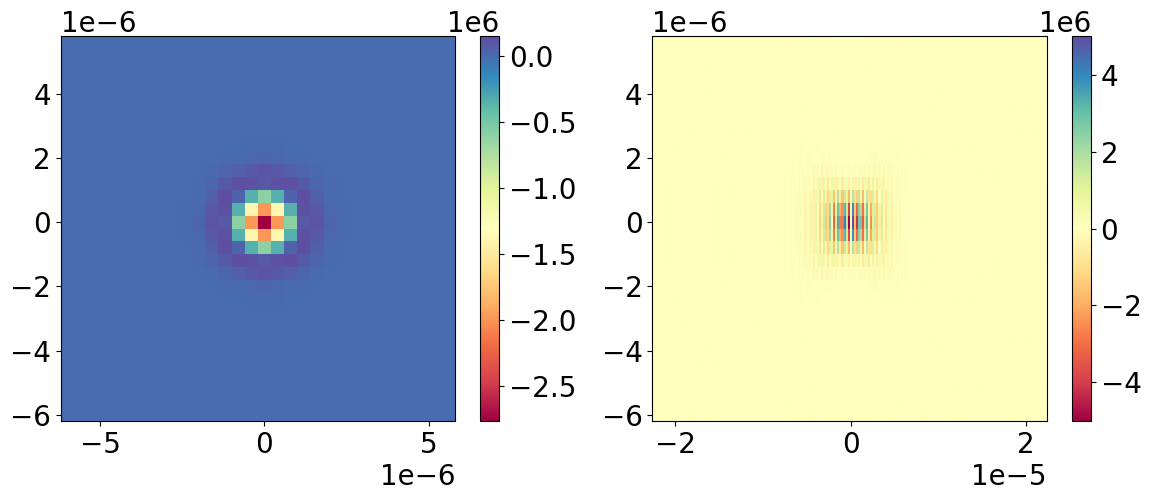

In [17]:
E = E_out[0]
print(E.max())
idx = nz//2-5
print(E[:,:,idx].max())

idx = nz//2-5
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(x, y, np.real(E[:,:,idx]), cmap='Spectral')
plt.colorbar()

idx = 15
plt.subplot(1,2,2)
plt.pcolormesh(z, x, np.real(E[:,idx,:]), cmap='Spectral')
plt.colorbar()
plt.show()

## Test: two paraxial gaussians for different collision angles

In [16]:
tau = 15e-15
W = 25
lam = 0.8e-6
w0 = 4*lam
theta = 145
beta = 90

field_1 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]

x0, y0, z0 = 5*c*tau, 15*w0, 5*c*tau
L = np.array([x0, y0, z0])
Nxyz = get_xyz_size(fields_params, L/2)
print(Nxyz)
Nx, Ny, Nz = Nxyz
x = np.linspace(-x0/2,x0/2,2*Nx)
y = np.linspace(-y0/2,y0/2,2*Ny)
z = np.linspace(-z0/2,z0/2,2*Nz)
grid = GridXYZ((x, y, z))

t0 = 2*tau
Nt = get_t_size(-t0, t0, lam)
print(Nt)
t_grid = np.linspace(-t0, t0, Nt)

[72, 30, 104]
135


### Single simulation

In [17]:
N_signal, N_perp = get_two_paraxial_scaling(fields_params)
print(f'Signal (theory): {N_signal:.3f}')

Signal (theory): 4.284


In [18]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field, grid)
vacem.calculate_amplitudes(t_grid)
N_signal_num = vacem.calculate_total_signal()
print(f'Signal (num)   : {N_signal_num:.3f}')

Signal (num)   : 3.232


### Different collision angles

In [4]:
thetas = np.linspace(10,180,18)
Ntots = np.zeros_like(thetas)
Nths = np.zeros_like(thetas)

In [7]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]

    x0, y0, z0 = 4*c*tau, 12*w0, 4*c*tau
    L = np.array([x0, y0, z0])
    Nxyz = get_xyz_size(fields_params, L/2)
    print(Nxyz)
    Nx, Ny, Nz = Nxyz
    x = np.linspace(-x0/2,x0/2,Nx)
    y = np.linspace(-y0/2,y0/2,Ny)
    z = np.linspace(-z0/2,z0/2,Nz)
    grid = GridXYZ((x, y, z))
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field, grid)
    vacem.calculate_amplitudes(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

    N_signal, N_perp = get_two_paraxial_scaling(fields_params)
    Nths[i] = N_signal

  0%|                                                         | 0/18 [00:00<?, ?it/s]

[25, 24, 84]


  6%|██▋                                              | 1/18 [00:02<00:38,  2.29s/it]

[39, 24, 84]


 11%|█████▍                                           | 2/18 [00:05<00:45,  2.85s/it]

[52, 24, 84]


 17%|████████▏                                        | 3/18 [00:09<00:51,  3.42s/it]

[63, 24, 84]


 22%|██████████▉                                      | 4/18 [00:15<01:02,  4.43s/it]

[72, 24, 84]


 28%|█████████████▌                                   | 5/18 [00:21<01:06,  5.12s/it]

[78, 24, 84]


 33%|████████████████▎                                | 6/18 [00:28<01:09,  5.76s/it]

[84, 24, 84]


 39%|███████████████████                              | 7/18 [00:35<01:07,  6.15s/it]

[84, 24, 84]


 44%|█████████████████████▊                           | 8/18 [00:42<01:04,  6.40s/it]

[84, 24, 84]


 50%|████████████████████████▌                        | 9/18 [00:49<00:59,  6.61s/it]

[84, 24, 84]


 56%|██████████████████████████▋                     | 10/18 [00:56<00:53,  6.72s/it]

[84, 24, 84]


 61%|█████████████████████████████▎                  | 11/18 [01:03<00:47,  6.80s/it]

[78, 24, 84]


 67%|████████████████████████████████                | 12/18 [01:10<00:40,  6.83s/it]

[72, 24, 84]


 72%|██████████████████████████████████▋             | 13/18 [01:16<00:32,  6.59s/it]

[63, 24, 84]


 78%|█████████████████████████████████████▎          | 14/18 [01:22<00:25,  6.34s/it]

[52, 24, 84]


 83%|████████████████████████████████████████        | 15/18 [01:26<00:17,  5.71s/it]

[39, 24, 84]


 89%|██████████████████████████████████████████▋     | 16/18 [01:30<00:09,  4.95s/it]

[25, 24, 84]


 94%|█████████████████████████████████████████████▎  | 17/18 [01:32<00:04,  4.09s/it]

[np.int64(11), 24, 84]


100%|████████████████████████████████████████████████| 18/18 [01:33<00:00,  5.19s/it]


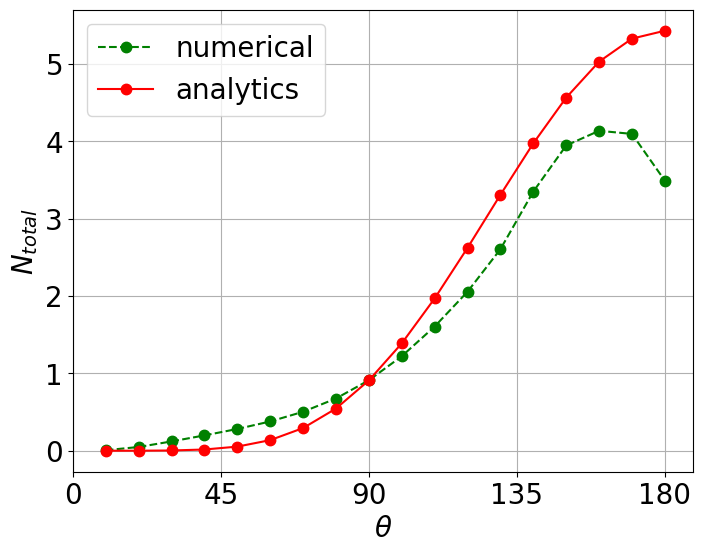

In [8]:
# This is for comparison with Fig.6 from H. Gies, et al "All-optical signatures of 
# strong-field QED in the vacuum emission picture." Physical Review D 97.3 (2018): 036022.

plt.figure(figsize=(8,6))
plt.plot(thetas, Ntots, '.--', color='green', ms=15, label='numerical')
plt.plot(thetas, Nths, '.-', color='red', ms=15, label='analytics')
# plt.yscale('log')
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
# plt.yticks([50*i for i in range(7)])
plt.legend(loc='best')

plt.savefig(f'../imgs/tests/2_paraxial_Ntot_theta_{theta}_beta_{beta}.png',
            bbox_inches='tight')
plt.show()

### Compare with Alex simulations

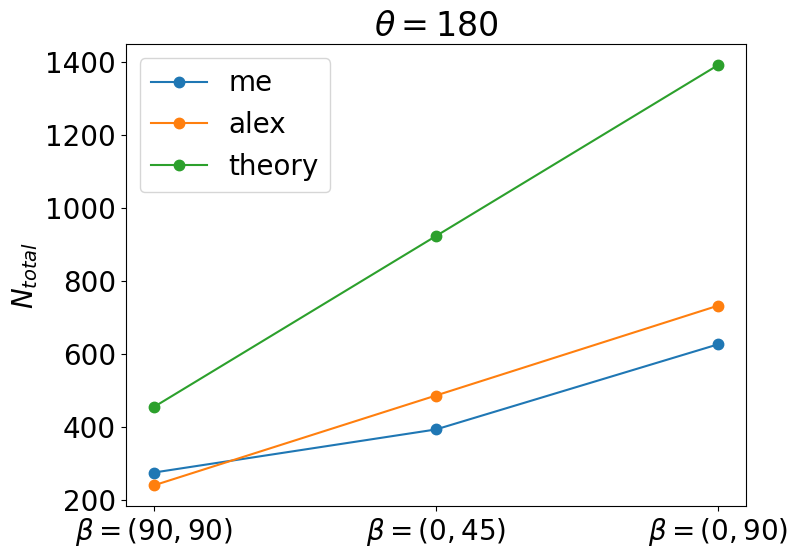

In [57]:
my_data = [274, 392, 625]
alex_data = [239, 485, 731]
theory_data = [454, 922, 1390]

plt.figure()
plt.plot(my_data, '.-', ms=15, label='me')
plt.plot(alex_data, '.-', ms=15, label='alex')
plt.plot(theory_data, '.-', ms=15, label='theory')
plt.xticks([0,1,2], labels=['$\\beta=(90,90)$', '$\\beta=(0,45)$', '$\\beta=(0,90)$'])
plt.ylabel("$N_{total}$")
plt.title('$\\theta = 180$')
plt.legend()
plt.show()

## Test Euler rotation

In [27]:
from scipy.spatial.transform import Rotation
phi = 67*np.pi/180
theta = 145*np.pi/180
beta = 45*np.pi/180
k = np.array([np.cos(phi)*np.sin(theta),
              np.sin(phi)*np.sin(theta),
              np.cos(theta)])
print(f'k      : {k}')
e1 = np.array([np.cos(phi)*np.cos(theta),
               np.sin(phi)*np.cos(theta),
               -np.sin(theta)])
e2 = np.array([-np.sin(phi),
               np.cos(phi),
               0.])
eb = e1 * np.cos(beta) + e2 * np.sin(beta)

rotation = Rotation.from_euler('ZYZ', (phi,theta,beta))
rotation_bwd = rotation.inv()

k_rotated = rotation_bwd.apply(k)
print(f'k(rot) : {k_rotated}')

eb_rotated = rotation_bwd.apply(eb)
print(f'eb     : {eb}')
print(f'eb(rot): {eb_rotated}')

eb_ = rotation.apply(eb_rotated)
print(f'eb...  : {eb_}')

k      : [ 0.22411417  0.52797989 -0.81915204]
k(rot) : [-2.77555756e-17 -5.55111512e-17  1.00000000e+00]
eb     : [-0.87721762 -0.25689352 -0.40557979]
eb(rot): [ 1.00000000e+00 -8.32667268e-17  0.00000000e+00]
eb...  : [-0.87721762 -0.25689352 -0.40557979]


## Random tests

In [19]:
from astropy.coordinates import cartesian_to_spherical

xyz = x,y,z = [np.linspace(-1,1,100)[:,None,None],
               np.linspace(-1,1,100)[None,:,None],
               np.linspace(-1,1,100)[None,None,:]]
sph = r,theta,phi = cartesian_to_spherical(*xyz)
sph = r,theta,phi = [np.array(coord) for coord in sph]
theta += np.pi/2
print(r.min(), r.max())
print('='*20)
print(theta.min(), theta.max())
print('='*20)
print(phi.min(), phi.max())
print('='*20)

0.017495462702715854 1.7320508075688772
0.014284013928896666 3.1273086396608964
0.010100666585321971 6.273084640594265


## Check how various DFTs work

In [20]:
import numpy as np
import pyfftw
from scipy.constants import pi
from scipy.special import sinc

def gauss(x, a=1.):
    return np.exp(-a*x**2)

def gauss_f(kx, a=1.):
    return np.sqrt(pi/a) * np.exp(-kx**2/(4*a))

def gauss_c(x, a=1.):
    return np.exp(-1j*pi*a*x**2)

def gauss_c_f(kx, a=1.):
    return 1/np.sqrt(a) * np.exp(-1j*pi/4) * np.exp(1j*kx**2/(4*pi*a))

def exp_c(x, a=1.):
    return np.exp(1j*a*x)

def exp_c_f(kx, x0, a=1.):
    return 2*x0 * sinc(x0*(kx-a))

def cft_numpy(arr, x, fft_module='numpy'):
    fft_module = np.fft if fft_module == 'numpy' else pyfftw.interfaces.numpy_fft
    dx = x[1] - x[0]
    kx = 2.*pi*np.fft.fftshift(np.fft.fftfreq(len(x), dx))
    kx0 = kx[0]

    arr_k = fft_module.fftn(arr*np.exp(-1j*kx0*(x-x[0])))
    arr_k_shifted = dx * arr_k * np.exp(-1j*kx*x[0]+1j*kx0*x[0])
    return arr_k_shifted, kx

def icft_numpy(arr_k, kx, fft_module='numpy'):
    fft_module = np.fft if fft_module == 'numpy' else pyfftw.interfaces.numpy_fft
    dkx = kx[1] - kx[0]
    kx = np.fft.fftshift(kx.copy())
    x = np.fft.fftshift(np.fft.fftfreq(len(kx), dkx/(2*pi)))

    arr_k = np.fft.fftshift(arr_k)
    arr = fft_module.ifftn(arr_k*np.exp(1j*(kx-kx[0])*x[0]), norm='forward')
    arr_shifted = dkx/(2*pi) * arr * np.exp(1j*kx[0]*x-1j*kx[0]*x[0])
    return arr_shifted, x

# Write analogs with pyfftw
def cft_pyfftw(arr, x):
    dx = x[1] - x[0]
    kx = 2*pi*np.fft.fftshift(np.fft.fftfreq(len(x), dx))
    kx0 = kx[0]

    arr = arr.astype(np.complex128) * np.exp(-1j*kx0*(x-x[0]))
    arr_k = np.zeros(arr.shape, dtype=np.complex128)
    pyfftw_scheme = pyfftw.FFTW(arr, arr_k, axes=(0,),
                                direction='FFTW_FORWARD',
                                flags=('FFTW_MEASURE', ),
                                threads=1)
    pyfftw_scheme.execute()
    
    arr_k_shifted = dx * arr_k * np.exp(-1j*kx*x[0]+1j*kx0*x[0])
    return arr_k_shifted, kx

def icft_pyfftw(arr_k, kx):
    dkx = kx[1] - kx[0]
    x = np.fft.fftshift(np.fft.fftfreq(len(kx), dkx/(2*pi)))
    kx = np.fft.fftshift(kx.copy())

    arr_k = np.fft.fftshift(arr_k)
    arr_k = arr_k.astype(np.complex128) * np.exp(1j*(kx-kx[0])*x[0])
    arr = np.zeros_like(arr_k)
    pyfftw_scheme = pyfftw.FFTW(arr_k, arr, axes=(0,),
                                direction='FFTW_BACKWARD',
                                flags=('FFTW_MEASURE', ),
                                threads=1)
    pyfftw_scheme.execute()
    
    arr_shifted = dkx/(2*pi) * arr * np.exp(1j*kx[0]*x-1j*kx[0]*x[0])
    return arr_shifted, x

200
[1.91516960e-174 5.48518544e-171 1.45021313e-167 3.53939303e-164
 7.97410943e-161]
[1.91516960e-174 5.48518544e-171 1.45021313e-167 3.53939303e-164
 7.97410943e-161]
True


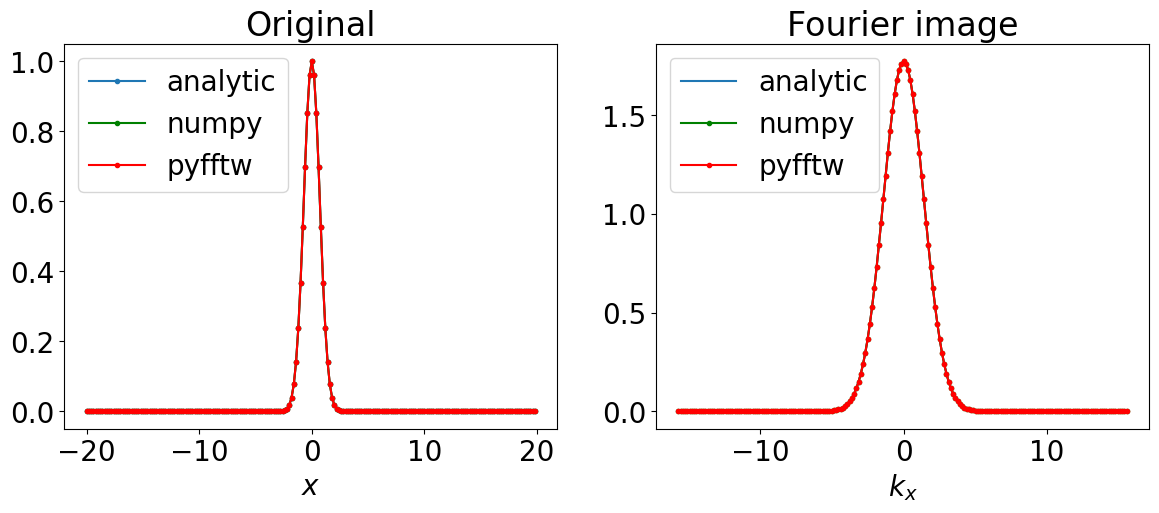

In [18]:
x0 = 20
dx = 0.2
Nx = int(2*x0/dx)
# dx = 2*x0/Nx
x = np.linspace(-x0, x0, Nx, endpoint=Nx%2)
kx = np.fft.fftshift(2.*pi*np.fft.fftfreq(Nx, dx))
print(Nx)

a = 1.
f = gauss(x, a)
# Analytic CFT
fk = gauss_f(kx, a)
print(f[:5])

# Numeric
module = 'numpy'
fk_np, kx_fft = cft_numpy(f, x, fft_module=module)
f_np, x_fft = icft_numpy(fk_np, kx_fft, fft_module=module)

print(f[:5])
fk_pyfftw, kx_pyfftw = cft_pyfftw(f, x)
f_pyfftw, x_pyfftw = icft_pyfftw(fk_pyfftw, kx_pyfftw)

print(np.allclose(f, f_np, rtol=1e-1))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(x, f, '.-', label='analytic')
plt.plot(x_fft, f_np, '.-', color='green', label='numpy')
plt.plot(x_pyfftw, f_pyfftw, '.-', color='red', label='pyfftw')
plt.xlabel('$x$')
plt.title('Original')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(kx, fk, label='analytic')
plt.plot(kx_fft, fk_np, '.-', color='green', label='numpy')
plt.plot(kx, fk_pyfftw, '.-', color='red', label='pyfftw')
plt.xlabel('$k_x$')
plt.title('Fourier image')
plt.legend(loc='upper left')
plt.show()

2000
[0.96496603+0.26237485j 0.9506468 +0.31027515j 0.93395144+0.35739993j
 0.91492169+0.40363139j 0.89360512+0.44885398j]
[0.96496603+0.26237485j 0.9506468 +0.31027515j 0.93395144+0.35739993j
 0.91492169+0.40363139j 0.89360512+0.44885398j]
True


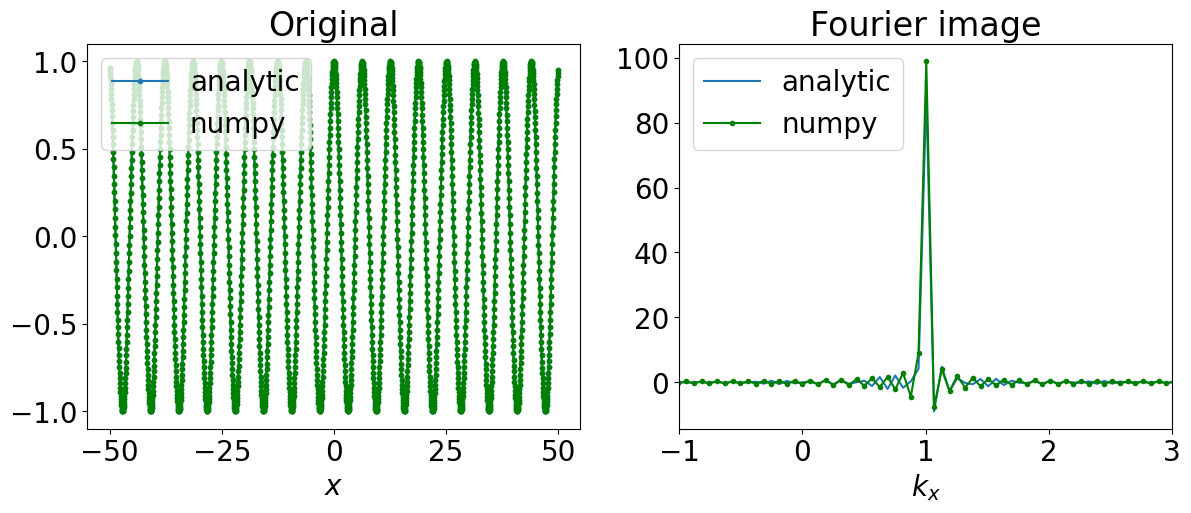

In [34]:
x0 = 50
dx = 0.05
Nx = int(2*x0/dx)
# dx = 2*x0/Nx
x = np.linspace(-x0, x0, Nx, endpoint=Nx%2)
kx = np.fft.fftshift(2.*pi*np.fft.fftfreq(Nx, dx))
print(Nx)

a = 1.
f = exp_c(x, a)
# Analytic CFT
fk = exp_c_f(kx, x0, a)
print(f[:5])

# Numeric
module = 'numpy'
fk_np, kx_fft = cft_numpy(f, x, fft_module=module)
f_np, x_fft = icft_numpy(fk_np, kx_fft, fft_module=module)

print(f[:5])
fk_pyfftw, kx_pyfftw = cft_pyfftw(f, x)
f_pyfftw, x_pyfftw = icft_pyfftw(fk_pyfftw, kx_pyfftw)

print(np.allclose(f, f_np, rtol=1e-1))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(x, f, '.-', label='analytic')
plt.plot(x_fft, f_np, '.-', color='green', label='numpy')
# plt.plot(x_pyfftw, f_pyfftw, '.-', color='red', label='pyfftw')
plt.xlabel('$x$')
plt.title('Original')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(kx, fk, label='analytic')
plt.plot(kx_fft, fk_np, '.-', color='green', label='numpy')
# plt.plot(kx, fk_pyfftw, '.-', color='red', label='pyfftw')
plt.xlim([-1,3])
plt.xlabel('$k_x$')
plt.title('Fourier image')
plt.legend(loc='upper left')
plt.show()

## Check spherical interpolator

In [12]:
from scipy.interpolate import RegularGridInterpolator

def sph2cart(r,phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x,y

In [17]:
x = np.linspace(-5,5,11)
y = np.linspace(-10,10,21)

xg, yg = np.meshgrid(x, y, indexing='ij', sparse=True)
a = xg + yg

arr_interp = RegularGridInterpolator((x,y), a, method='linear')

# Desired spherical grid
nr, nphi = 11, 19
r = np.linspace(0, 5, nr)
phi = np.linspace(0, 2*np.pi, nphi)

rg, phig = np.meshgrid(r, phi, indexing='ij')
xnew, ynew = sph2cart(rg,phig)

pts = np.vstack([xnew.flatten(), ynew.flatten()]).T
print(pts.shape)
arr_new = arr_interp(pts).reshape((nr,nphi))

(209, 2)


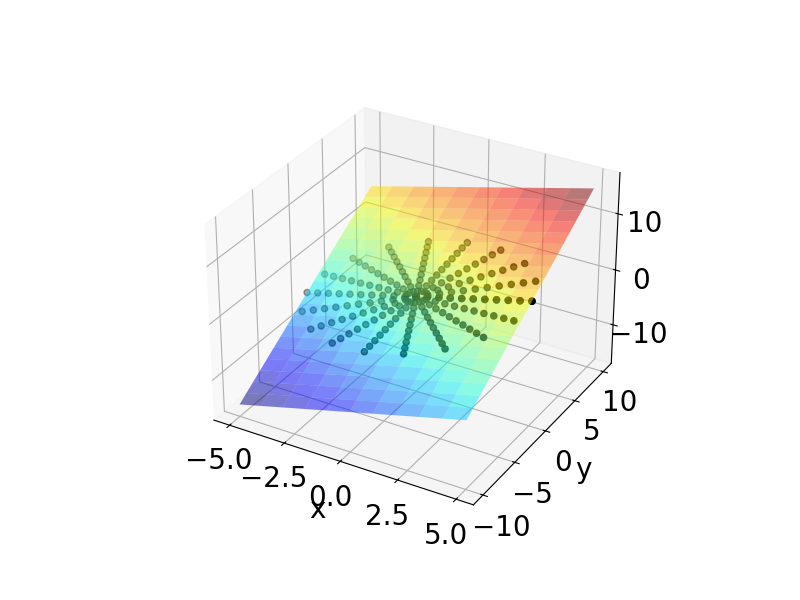

In [16]:
%matplotlib widget

ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xg, yg, a, cmap='jet', alpha=0.5)
ax.scatter(xnew, ynew, arr_new, color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [6]:
from scipy.integrate import trapezoid
a = np.ones((4,5))
b = trapezoid(a, axis=1)
b.shape

(4,)

In [7]:
a = 'N_xyz'
a.replace('xyz', 'sph')

'N_sph'